In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pygimli as pg
from SimPEG.electromagnetics import time_domain
from SimPEG import (
    optimization,
    discretize,
    maps,
    data_misfit,
    regularization,
    inverse_problem,
    inversion,
    directives,
    utils,
)

# Modèle EM - Frenquency domaine

In [3]:
# Modèle de resistivité :
    
res_map = np.empty((30,200),dtype='float')
res_map[0:10,:] = 200
res_map[10:20,:] = 20
res_map[20:30,:] = 100

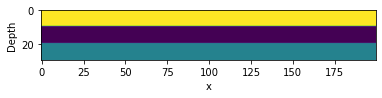

In [4]:
plt.imshow(res_map)
plt.xlabel('x')
plt.ylabel('Depth');

In [5]:
position_x = 98 # position initiale du modèle
noiseEM = 1 
nlay = 40
thickness = 1

thk = pg.Vector(nlay - 1, thickness)  # épaisseur de chaque couche (1m)
centroids = np.cumsum(thk)-thk/2 # centroïde des couches

# On sample dans le model "res_map" la résistivité correspondant aux position de couches. 
res_EM = np.ones(nlay) *  res_map[0,position_x]
    

Inversion de l'indexing :

- référence en bas à gauche et en haut à gauche

- si on prend le 0 du premier modèle il faut le placer dans le 0 de l'autre et inversément
    

In [6]:
for i in centroids:
    if i < 30:
        ab = 29 - np.round((i-0.01)).astype(int) # index dans le modèle resmap
        ab2 = np.floor(i/thickness).astype(int) # index dans le modèle EM
        res_EM[ab2] = res_map[ab,position_x]

Mise en commun des modèles

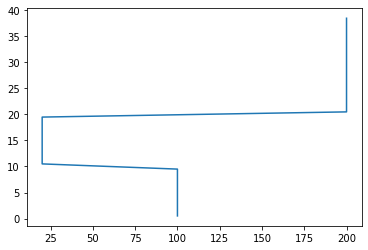

In [7]:
model = pg.cat(thk, res_EM)
noiseEM = 1
plt.plot(np.array(res_EM)[:-1],np.array(centroids));

Valeurs du model :

In [8]:
model.array()

array([  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100.,  20.,  20.,  20.,  20.,  20.,  20.,
        20.,  20.,  20.,  20., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200.])

Fréquences utilisées

In [9]:
coilspacing = 10
nf = 10
freq = pg.Vector(nf)
freq[0] = 100
freq[1] = 400
freq[2] = 600
freq[3] = 1000
freq[4] = 5000
freq[5] = 8000
freq[6] = 9000
freq[7] = 10000
freq[8] = 20000
freq[9] = 30000

Fonction du modèle

In [10]:
fEM = pg.core.FDEM1dModelling(nlay, freq, coilspacing) # coilspacing : espacement des boucles
dataEM = fEM(model)

Bruit possible :

In [11]:
for i in range(len(dataEM)):
    dataEM[i] += np.random.random(1)[0] * 0.1

Plot du modèle :

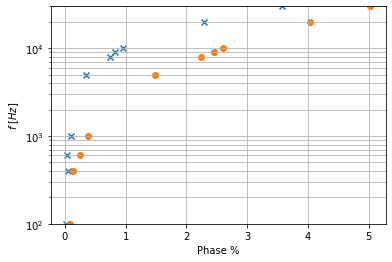

In [12]:
plt.scatter(dataEM[:nf], freq, marker = 'x')
plt.scatter(dataEM[nf:nf*2], freq, marker = 'o')
plt.yscale('log')
plt.ylim((min(freq), max(freq)))
plt.grid(which='both')
plt.xlabel('Phase %')
plt.ylabel('$f$ $[Hz]$');

Alternative qui utilise des fonctions équivalentes 

In [13]:
#Une autre méthode pour comparer. Ca a l'air de donner les memes datas
Data_box_FEM = pg.physics.em.FDEM(x=[1],freqs=freq,coilSpacing=coilspacing)
FOP = pg.core.FDEM1dRhoModelling(centroids, Data_box_FEM.freq(), Data_box_FEM.coilSpacing,-Data_box_FEM.height)
dataEM = FOP(res_EM)

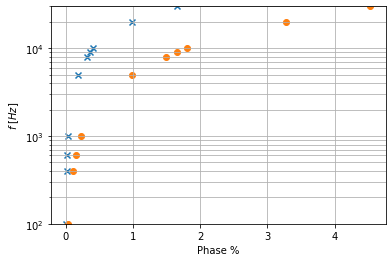

In [14]:
plt.scatter(dataEM[:nf], freq, marker = 'x')
plt.scatter(dataEM[nf:nf*2], freq, marker = 'o')
plt.yscale('log')
plt.ylim((min(freq), max(freq)))
plt.grid(which='both')
plt.xlabel('Phase %')
plt.ylabel('$f$ $[Hz]$');

## Inversion FDEM

But : retrouver notre modèle initial à partir des données

In [15]:
transRhoa = pg.trans.TransLog() # paramètre initial - no limit sur les couches
transThk = pg.trans.TransLog()
transRes = pg.trans.TransLogLU(1., 1000.) # limitation des résistivités - entre 1 et 1000 ohmm
transEM = pg.trans.Trans()

nombre de couche au modèle

In [16]:
nLayer_inv = 20 # nombre de layer du modèle inverse

Modèle initial, avant inversion. 2m de couches, uniformes à 10 ohmm

In [17]:
thk_inv = pg.Vector(nLayer_inv - 1, 2)  # 2m d'épaisseur par couches
res_inv = np.ones(nLayer_inv) *  10
initial_model = pg.cat(thk_inv, res_inv)  # mise en commun du modèle

Paramètres principaux -> énorme influence sur le résultat.

In [18]:
fEM_inv = pg.core.FDEM1dModelling(nLayer_inv, freq, coilspacing)
fEM_inv.region(0).setTransModel(transThk)
fEM_inv.region(1).setTransModel(transRes)
lamEM =  100 # paramètre de régulation pour le modèle

Les fameux modèles -> non uniqueness des solutions qui dépendent des paramètres.

In [19]:
invEM = pg.core.Inversion(dataEM, fEM_inv, transEM)
invEM.setModel(initial_model)
invEM.setRelativeError(0.1/100)
invEM.setLambda(lamEM)
invEM.setMarquardtScheme(0.8)
invEM.setDeltaPhiAbortPercent(0.00001)
invEM.setMaxIter(40)
invEM.setBlockyModel(True)

Finalisation du modèle EM

In [20]:
modelEM = invEM.run()
respEM = invEM.response()

Données

In [21]:
np.array(modelEM)

array([  1.93400201,  31.49422985,  22.21507858,   1.65996754,
         1.33161617,   1.64614752,   2.44119662,   4.10523315,
         5.62064623,   5.77849314,   4.90493499,   3.90728612,
         3.20971896,   2.83877486,   2.70178263,   2.70134905,
         2.75923596,   2.8199153 ,   2.85201843, 997.96655991,
        77.73588463, 271.49025106,   7.37465579,   1.97991604,
         6.52721654,  34.12797029,  76.36224426,  96.79095406,
        94.00357883,  77.09599928,  54.46166804,  33.77664358,
        19.40641118,  11.22776169,   7.06945497,   5.04824133,
         4.08590954,   3.66050876,  39.05362115])

Plot

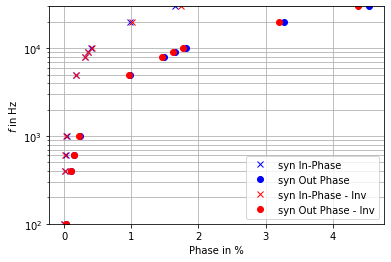

In [22]:
plt.semilogy(dataEM[0:nf], freq, 'bx', label='syn In-Phase')
plt.semilogy(dataEM[nf:nf*2], freq, 'bo', label='syn Out Phase')
plt.semilogy(respEM[0:nf], freq, 'rx', label='syn In-Phase - Inv')
plt.semilogy(respEM[nf:nf*2], freq, 'ro', label='syn Out Phase - Inv')
plt.ylim((min(freq), max(freq)))
plt.xlabel("Phase in %")
plt.ylabel("$f$ in Hz")
plt.grid(which='both')
plt.legend(loc="best");

Reconstruction du modèle initial

In [23]:
model_Final = np.array(modelEM)
cetr = np.cumsum(model_Final[0:nLayer_inv-2])
res_Final = model_Final[nLayer_inv-1:-2]

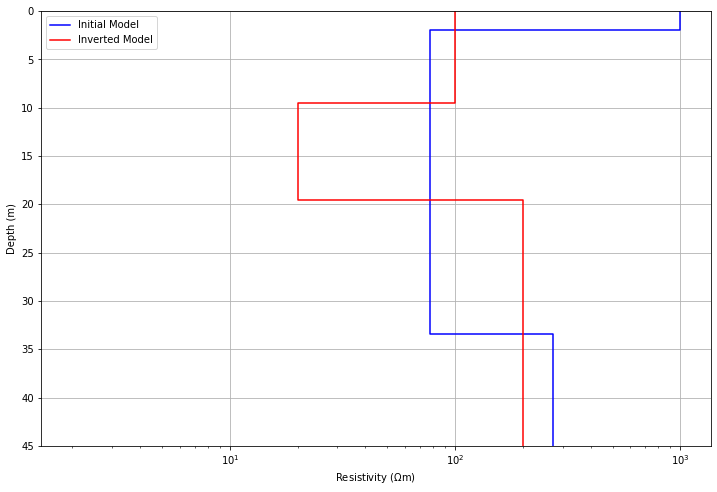

In [24]:
fig, ax = plt.subplots(figsize = ((12,8)))
pg.viewer.mpl.drawModel1D(ax, values=res_Final, depths=cetr,plot='semilogx', 
                          color='blue',label='Initial Model')
pg.viewer.mpl.drawModel1D(ax, values=res_EM[:-1], depths=centroids,plot='semilogx', 
                          color='red',label='Inverted Model')
plt.legend();